# Variational Autoencoders en Anime Faces

Para este ejercicio, entrenará un codificador automático variacional (VAE) utilizando el [conjunto de datos de caras de anime de MckInsey666](https://github.com/bchao1/Anime-Face-Dataset).

Entrenarás el modelo utilizando las técnicas discutidas en clase. Al final, debe guardar su modelo y descargarlo de Colab para poder enviarlo al autocalificador para su calificación.

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display
import warnings
warnings.filterwarnings("ignore")

## Parameters

In [ ]:
# set a random seed
np.random.seed(51)

# parameters for building the model and training
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

## Download the Dataset

Descargar el dataset en un directorio local o utilizar `Google Drive`. En el caso de usar Google Drive, subir el archivo a un direterminado y luego copiar el `path` en las variables `os.mkdir`, `data_file_name`, `downloa_dir`, y `get_dataset_slice_paths`

[Link Descarga Dataset](https://drive.google.com/file/d/1YjP9-APc-LzEYbpu4egkBER0dgIQkSfc/view?usp=drive_link)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# make the data directory
try:
  os.mkdir('./sample_data/anime') #TODO
except OSError:
  pass

data_file_name = '/content/drive/MyDrive/animefaces.zip' #TODO
download_dir = './sample_data/anime/tmp/' #TODO

# extract the zip file
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

## Prepare the Dataset

Luego, prepararemos los datos para entrenamiento y validación. Debajo encontrarás algunas funciones útiles.

In [ ]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

Utilizaremos dichas funciones para armar el set de entrenamiento y el de validación.

In [ ]:
# get the list containing the image paths
paths = get_dataset_slice_paths("./sample_data/anime/tmp/images/") #TODO

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.80 ) #TODO - Completar el porcentaje de entrenamiento

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


## Display Utilities

Aquí tienes algunas funciones que te ayudarán a visualizar imágenes.

In [ ]:
import numpy as np
def display_faces(dataset, size=9):
  '''Takes a sample from a dataset batch and plots it in a grid.'''
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64, 64, 3)) #TODO - (Height, Width, Channel)
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Displays a row of images.'''
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  '''Displays input and predicted images.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


Veamos algunas imágenes del dataset de entrenamiento.

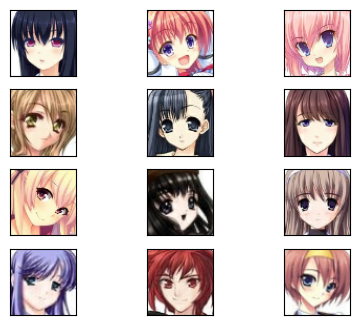

In [ ]:
display_faces(validation_dataset, size=12)

## Build the Model

Construirás tu VAE en las siguientes secciones. Recuerda que esto seguirá la arquitectura codificador-decodificador y se puede resumir en la siguiente figura.

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

### Sampling Class

Comenzará con la capa personalizada para proporcionar la entrada de ruido gaussiano junto con la media (mu) y la desviación estándar (sigma) de la salida del codificador. Recuerde la ecuación para combinar estos:

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

donde $\mu$ = mean, $\sigma$ = standard deviation, y $\epsilon$ = random sample

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """
    ### START CODE HERE ###
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
    z = mu + tf.exp(0.5 * sigma) * epsilon
    ### END CODE HERE ###
    return  z

### Encoder Layers

A continuación, utilice la API funcional para apilar las capas del codificador y generar `mu`, `sigma` y la forma de las características antes de aplanarlas. Esperamos que utilices 3 capas convolucionales, pero siéntase libre de revisarlas como mejor te parezca. Otra sugerencia es usar unidades `1024` en la capa Densa antes de obtener `mu` y `sigma`.

In [ ]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_3.shape -- shape of the features before flattening
  """
  ### START CODE HERE ###
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides = 2,
                             activation = 'relu', padding = 'same',
                             name = 'enc_conv1')(inputs) #TODO Completar capa de activación
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 2,
                             activation = 'relu', padding = 'same',
                             name = 'enc_conv2')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 2,
                             activation = 'relu', padding = 'same',
                             name = 'enc_conv3')(x) #TODO Completar capa de activación
  batch_3 = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Flatten(name = 'enc_flatten')(batch_3)

  x = tf.keras.layers.Dense(1024, activation = 'relu', name = 'enc_dense')(x) #TODO Completar capa de activación
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_mu')(x)
  sigma = tf.keras.layers.Dense(LATENT_DIM, name = 'latent_sigma')(x)
  ### END CODE HERE ###

  # revise `batch_3.shape` here if you opted not to use 3 Conv2D layers
  return mu, sigma, batch_3.shape

### Encoder Model

Alimentará la salida de la función anterior a la `Sampling layer` que definió anteriormente. Eso tendrá las representaciones latentes que se pueden enviar a la red decodificadora más adelante. Complete la siguiente función para construir la red de codificadores con la `Sampling layer`.

In [ ]:
def encoder_model(latent_dim, input_shape):

  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim = LATENT_DIM)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs, outputs = [mu, sigma, z])
  model.summary()
  return model, conv_shape

### Decoder Layers

A continuación, definirá las capas del decodificador. Esto expandirá las representaciones latentes a las dimensiones de la imagen original. Después de entrenar su modelo VAE, puede usar este modelo de decodificador para generar nuevos datos alimentando entradas aleatorias.

In [ ]:
def decoder_layers(inputs, conv_shape):

  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name = 'dec_dense')(inputs) #TODO Completar capa de activación
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]),
                              name = 'dec_reshape')(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (3, 3),
                                      strides = 2, activation = 'relu',
                                      padding = 'same', name = 'dec_deconv1')(x) #TODO Completar capa de activación
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3),
                                      strides = 2, activation = 'relu',
                                      padding = 'same', name = 'dec_deconv2')(x) #TODO Completar capa de activación
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3, 3),
                                      strides = 2, activation = 'relu',
                                      padding = 'same', name = 'dec_deconv3')(x) #TODO Completar capa de activación
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = (3, 3),
                                      strides = 1, activation = 'sigmoid',
                                      padding = 'same', name = 'dec_deconv4')(x)
  return x

### Decoder Model

In [ ]:
def decoder_model(latent_dim, conv_shape):

  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """
  inputs = tf.keras.layers.Input(shape = (latent_dim, ))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  return model

### Kullback–Leibler Divergence

A continuación, definirás la función para calcular la pérdida de [Kullback-Leibler Divergencia](https://arxiv.org/abs/2002.07514). Esto se utilizará para mejorar la capacidad generativa del modelo. Este código ya está proporcionado.


In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

### Putting it all together

Define todo el modelo VAE. Recuerda usar `model.add_loss()` para agregar la pérdida de reconstrucción de KL. Se accederá a esto y se agregará a la pérdida más adelante en el ciclo de entrenamiento.

In [ ]:
def vae_model(encoder, decoder, input_shape):

  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  inputs = tf.keras.layers.Input(shape = input_shape)
  mu, sigma, z = encoder(inputs)
  reconstructed = decoder(z)

  model = tf.keras.Model(inputs, reconstructed)

  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

La siguiente función retornará los modelos `enconder`, `decoder`, y `VAE` que hemos definido.

In [ ]:
def get_models(input_shape, latent_dim):

  """Returns the encoder, decoder, and vae models"""

  encoder, conv_shape = encoder_model(latent_dim = latent_dim, input_shape = input_shape)
  decoder = decoder_model(latent_dim = latent_dim, conv_shape = conv_shape)
  vae = vae_model(encoder, decoder, input_shape = input_shape)

  return encoder, decoder, vae

In [ ]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 enc_conv1 (Conv2D)          (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32)           128       ['enc_conv1[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 enc_conv2 (Conv2D)          (None, 16, 16, 64)           18496     ['batch_normalization[0][0

## Train the Model

Ahora configurará el modelo para el entrenamiento. Definimos algunas pérdidas, el optimizador y la métrica de pérdidas a continuación, pero puedes experimentar con otras si lo deseas.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

Generarás 16 imágenes en una cuadrícula de 4x4 para mostrar
Progreso de la generación de imágenes. Hemos definido una función de utilidad para eso a continuación.

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):

  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    img = predictions[i, :, :, :] * 255
    img = img.astype('int32')
    plt.imshow(img)
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()


Ahora puedes iniciar el ciclo de entrenamiento. Se le pedirá que seleccione el número de épocas y que complete la subsección sobre la actualización de los pesos. Los pasos generales son:

- alimentar un lote de entrenamiento al modelo VAE
- calcule la pérdida de reconstrucción (sugerencia: use mse_loss definido anteriormente en lugar de bce_loss en el laboratorio sin calificar, luego multiplique por las dimensiones aplanadas de la imagen (es decir, 64 x 64 x 3)
- agregue la pérdida de regularización de KLD a la pérdida total (puede acceder a la propiedad de pérdidas del modelo vae)
- obtener los gradientes
- use el optimizador para actualizar los pesos

Al entrenar a tu `VAE`, es posible que notes que no hay mucha variación en las caras. ¡Pero no dejes que eso te desanime! Las pruebas se basarán en qué tan bien reconstruye las caras originales y no en qué tan bien crea caras nuevas.

El entrenamiento también llevará mucho tiempo (más de 30 minutos) y eso es de esperarse. Si utilizó la métrica de pérdida media sugerida anteriormente, entrene el modelo hasta que se reduzca a alrededor de `320` antes de enviarlo.

1/1 [==============================] - 0s 22ms/step


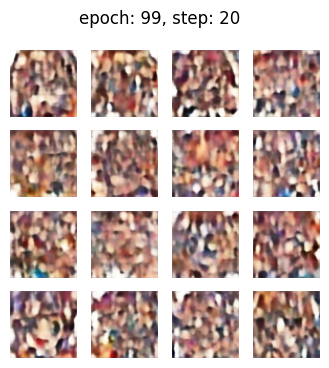

Epoch: 99 step: 20 mean loss = 250.66293
Epoch: 99 step: 21 mean loss = 250.61699
Epoch: 99 step: 22 mean loss = 250.57066
Epoch: 99 step: 23 mean loss = 250.52562
Epoch: 99 step: 24 mean loss = 250.4816
Epoch: 99 step: 25 mean loss = 250.43842


In [ ]:
# Training loop. Display generated images each epoch


epochs = 100


random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(training_dataset):
        with tf.GradientTape() as tape:

            reconstructed = vae(x_batch_train)
      # Compute reconstruction loss
            flattened_inputs = tf.reshape(x_batch_train, shape = [-1])
            flattened_outputs = tf.reshape(reconstructed, shape = [-1])
            loss = mse_loss(flattened_inputs, flattened_outputs) * 64 * 64 * 3
            loss += sum(vae.losses)
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    ### END CODE HERE

        loss_metric(loss)

        if step % 10 == 0:
            display.clear_output(wait=False)
            generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
        print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

# Plot Reconstructed Images


As mentioned, your model will be graded on how well it is able to reconstruct images (not generate new ones). You can get a glimpse of how it is doing with the code block below. It feeds in a batch from the test set and plots a row of input (top) and output (bottom) images. Don't worry if the outputs are a blurry. It will look something like below:

<img src="https://drive.google.com/uc?export=view&id=1OPMbZOxX9fx8tK6CGVbrMaQdgyOiQJIC" width="75%" height="60%"/>

1/1 [==============================] - 1s 1s/step


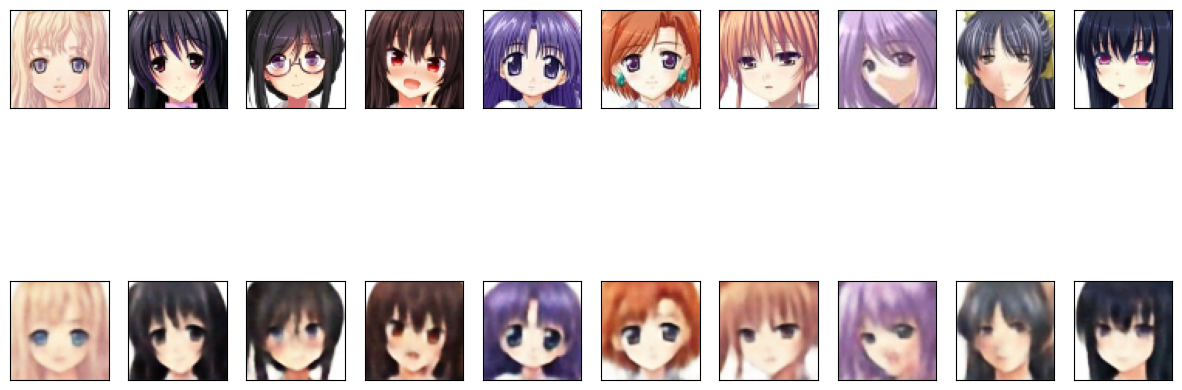

In [ ]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

# Plot Generated Images


Using the default parameters, it can take a long time to train your model well enough to generate good fake anime faces. In case you decide to experiment, we provided the code block below to display an 8x8 gallery of fake data generated from your model. Here is a sample gallery generated after 50 epochs.

<img src="https://drive.google.com/uc?export=view&id=1QwElgfg5TY6vCgI1FK6vdI8Bo6UZKfuX" width="75%" height="60%"/>

2/2 [==============================] - 0s 7ms/step


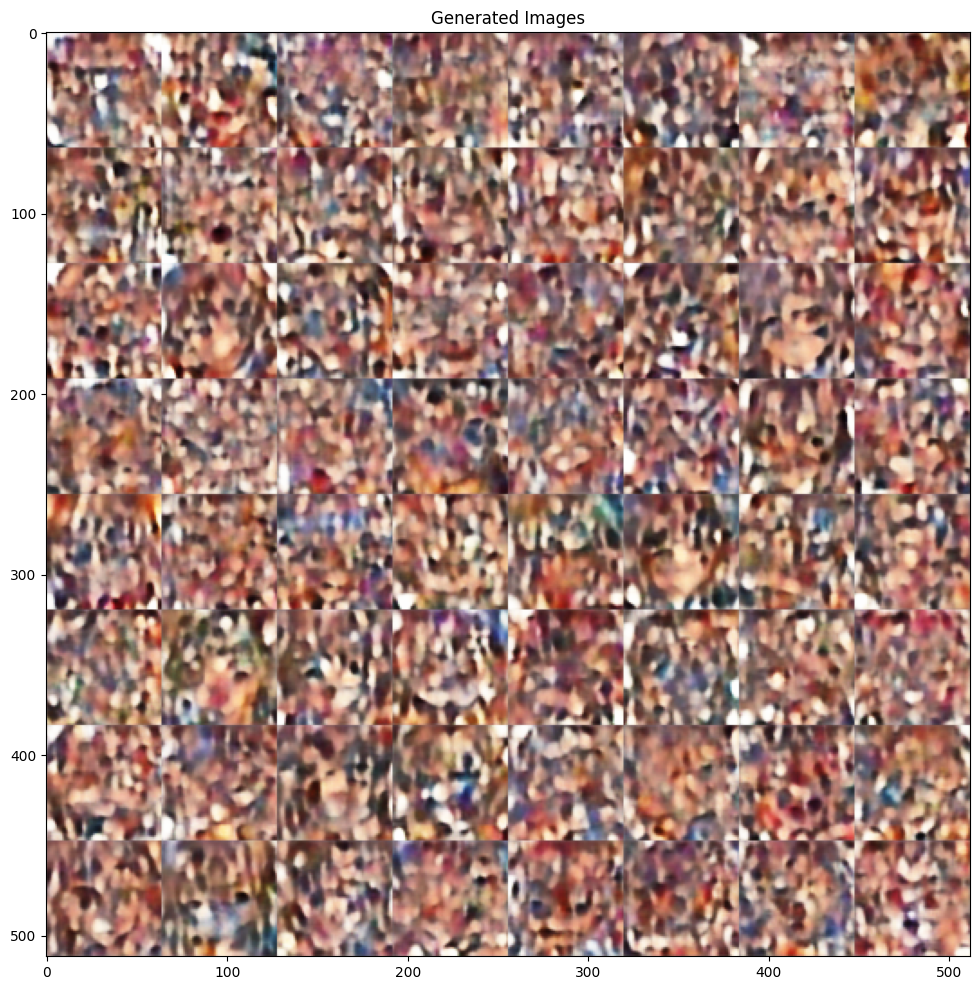

In [ ]:
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))
    plt.imshow(grid)
    plt.title(title)
    plt.show()

# initialize random inputs
test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

# get predictions from the decoder model
predictions= decoder.predict(test_vector_for_generation)

# plot the predictions
plot_images(8,8,predictions,'Generated Images')

### Save the Model

Once your satisfied with the results, please save and download the model. Afterwards, please go back to the Coursera submission portal to upload your h5 file to the autograder.

In [ ]:
vae.save("anime.h5")